# Machine Learning: Classification 
Goal of this notebook is to interpret data from Google Analytics and classify whether or not the session resulted in a transaction. Data for this notebook was source from Google Analytics sample data in BigQuery, with the query and data maintained in this notebook. Marketers can use this information to see which targeting features drive the highest impact on conversion probability!

## Part 0: Package Import
Goal:
- Import requisite packages

In [1]:
# Package Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sb
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import datetime
from datetime import timedelta
style.use('ggplot')

## Part 1: Data Import
Goal:
- Read in raw data from working directory
- Note - data source from BigQuery

In [2]:
# Data Import
rawData = pd.read_csv(r"rawData.csv", parse_dates = ['date'])

rawData.head()

,date,campaign,transactions,pageviews,ismobile,country
0,2016-09-23,Data Share Promo,0,1.0,False,India
1,2016-09-23,Data Share Promo,0,1.0,False,United Kingdom
2,2016-09-23,Data Share Promo,0,1.0,False,Czechia
3,2016-09-23,Data Share Promo,0,2.0,False,Czechia
4,2016-09-23,Data Share Promo,0,4.0,False,Turkey


## Part 2: Exploratory Analysis

In [3]:
# Info on the dataset
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10000 non-null  datetime64[ns]
 1   campaign      10000 non-null  object        
 2   transactions  10000 non-null  int64         
 3   pageviews     9999 non-null   float64       
 4   ismobile      10000 non-null  bool          
 5   country       10000 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 400.5+ KB


In [4]:
# Describing the dataset
rawData.describe()

,transactions,pageviews
count,10000.000000,9999.000000
mean,0.005500,4.013801
std,0.073961,6.323275
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,0.000000,4.000000
max,1.000000,121.000000


In [6]:
# Visualizing how many transactions we have to work with by Campaign

# Counting transactions by campaign
campaignTransactions = rawData.groupby(['campaign'], as_index = False)[['transactions','date']].agg(
    totalTransactions = ('transactions', 'sum'),
    minDate = ('date', 'min'),
    maxDate = ('date', 'max')
)

campaignTransactions

,campaign,totalTransactions,minDate,maxDate
0,AW - Accessories,24,2016-08-03,2017-06-05
1,AW - Apparel,0,2017-03-08,2017-05-21
2,AW - Dynamic Search Ads Whole Site,28,2016-08-03,2017-06-05
3,AW - Electronics,0,2016-08-03,2017-05-07
4,All Products,0,2016-09-09,2016-09-09
5,Data Share Promo,3,2016-08-03,2017-06-24


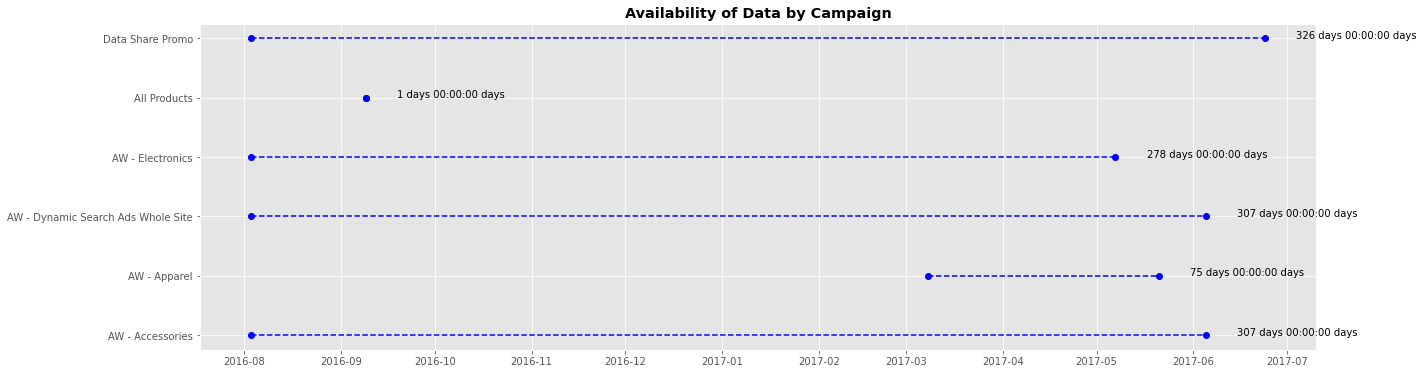

In [7]:
# Visualizing how much data we have available
plt.figure(figsize = (20,6))
for i in range(len(campaignTransactions)):
    x = [campaignTransactions['minDate'][i], campaignTransactions['maxDate'][i]]
    y = [campaignTransactions['campaign'][i], campaignTransactions['campaign'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(max(x) + timedelta(10), y[0], str(x[1] - x[0] + timedelta(1)) + str(' days'))
    plt.title('Availability of Data by Campaign', fontweight = 'bold')
plt.savefig('availability-of-data-by-campaign')
plt.show()

In [8]:
# Visualizing how many transactions we have to work with by Country
# Fitlered out countries with zero transactions

# Counting transactions by country
countryTransactions = rawData.loc[rawData['transactions'] > 0].groupby(['country'])[['transactions','date']].agg(
    totalTransactions = ('transactions', 'sum'),
    minDate = ('date', 'min'),
    maxDate = ('date', 'max')
)

countryTransactions

,totalTransactions,minDate,maxDate
country,,,
France,1,2016-12-24,2016-12-24
United States,54,2016-08-05,2017-05-30


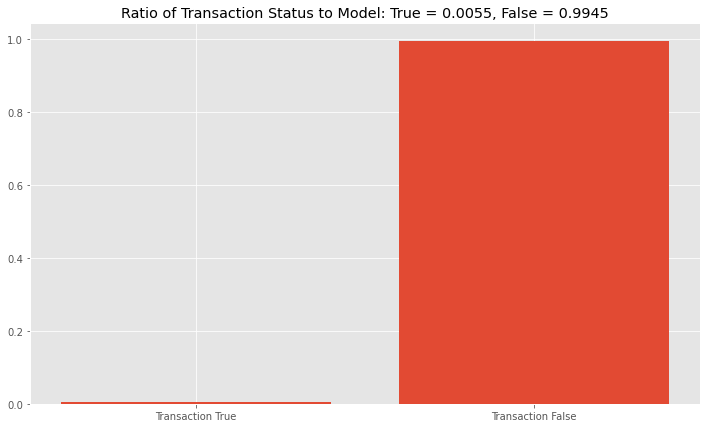

In [9]:
# Calculating ratio of total observations to total transactions to prep for classification
ratioTrue = rawData['transactions'].sum()/len(rawData)
ratioFalse = 1 - ratioTrue

plt.figure(figsize = (12,7))
plt.bar(
    x = ['Transaction True', 'Transaction False'],
    height = [ratioTrue, ratioFalse]
)
plt.title('Ratio of Transaction Status to Model: True = {}, False = {}'.format(ratioTrue, ratioFalse))
plt.show()

## Part 3: Data Processing
Goal:
- make a copy of raw data to protect it
- Convert categorical features to binary values
- Ensure all missing values are accounted for to prepare model
- drop country as it will likely skew the model due to USA weighting we saw in EDA
- get dummy variables for campaign
- split data into training and test splits

In [10]:
# Making a copy of raw data
df = rawData.copy()

# Sorting df by date, ascending
df.sort_values(by = 'date', ascending = True, inplace = True)

# Converting isMobile to int
df['ismobile'] = df['ismobile'].astype(int)

# Dropping country
df.drop('country', axis = 1, inplace = True)

# Getting dummy variables for campaign
campaignDummies = pd.get_dummies(df['campaign'])
df = pd.concat([df, campaignDummies], axis = 1)
df.drop('campaign', axis = 1, inplace = True)

# Dropping one dummy variable to avoid overfitting
df.drop('All Products', axis = 1, inplace = True)

# Gathering training and test splits
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

In [11]:
# Checking sets
print("Train set: {}".format(df_train.shape),
      "Test set: {}".format(df_test.shape)
     )

Train set: (7000, 9) Test set: (3000, 9)


## Part 4: Feature Selection
Goal:
- Decide which features are most important

In [31]:
# Setting the Random Forest Classifier
model = ensemble.RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)

# Setting X and y
y = df_train['transactions'].copy()
X = df_train.loc[:, ~df_train.columns.isin(['transactions', 'date'])] # removing unneeded columns
feature_names = X.columns

# Fitting model
model.fit(X, y)

# Making a dataframe with results
dfModel = pd.DataFrame(
    {
        'Feature Names' : X.columns,
        'Feature Importances' : model.feature_importances_
    }
)
    
dfModel

,Feature Names,Feature Importances
0,pageviews,0.847192
1,ismobile,0.031381
2,AW - Accessories,0.029072
3,AW - Apparel,0.000158
4,AW - Dynamic Search Ads Whole Site,0.023481
5,AW - Electronics,0.001841
6,Data Share Promo,0.066876
